In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=OPENAI_API_KEY
)

In [3]:
documents = [
    "LangGraph is a framework for building stateful, multi-agent AI workflows.",
    "Retrieval-Augmented Generation combines retrieval with LLM-based answering.",
    "Agentic AI systems use planning, tool usage, and reflection.",
    "Vector databases are commonly used to store embeddings for retrieval."
]

In [4]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

embeddings = OpenAIEmbeddings(api_key=OPENAI_API_KEY)
vectorstore = FAISS.from_texts(documents, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})

In [5]:
from typing import TypedDict, List

class RAGState(TypedDict):
    question: str
    context: List[str]
    answer: str
    retry_count: int

In [6]:
def retriever_node(state: RAGState) -> RAGState:
    docs = retriever.invoke(state["question"])
    context = [doc.page_content for doc in docs]

    return {
        **state,
        "context": context
    }


In [7]:
def generator_node(state: RAGState) -> RAGState:
    context_text = "\n".join(state["context"])

    prompt = f"""
Answer the question using ONLY the context below.
If the answer is not in the context, say "I don't know".

Context:
{context_text}

Question:
{state['question']}
"""

    response = llm.invoke(prompt)

    return {
        **state,
        "answer": response.content
    }


In [8]:
def critic_node(state: RAGState) -> RAGState:
    prompt = f"""
You are a critic agent.

Question:
{state['question']}

Context:
{state['context']}

Answer:
{state['answer']}

Is the answer fully supported by the context?
Answer only YES or NO.
"""

    response = llm.invoke(prompt)

    if "NO" in response.content.upper():
        return {
            **state,
            "retry_count": state["retry_count"] + 1
        }

    return state


In [9]:
def should_retry(state: RAGState) -> str:
    if state["retry_count"] >= 2:
        return "end"
    if "I don't know" in state["answer"]:
        return "retrieve"
    return "end"


In [10]:
from langgraph.graph import StateGraph, END

graph = StateGraph(RAGState)

graph.add_node("retrieve", retriever_node)
graph.add_node("generate", generator_node)
graph.add_node("critic", critic_node)

graph.set_entry_point("retrieve")

graph.add_edge("retrieve", "generate")
graph.add_edge("generate", "critic")

graph.add_conditional_edges(
    "critic",
    should_retry,
    {
        "retrieve": "retrieve",
        "end": END
    }
)

app = graph.compile()

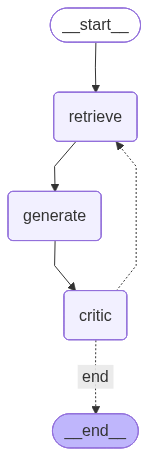

In [11]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
question = "What is RAG?"

initial_state: RAGState = {
    "question": question,
    "context": [],
    "answer": "",
    "retry_count": 0
}

final_state = app.invoke(initial_state)

print("\nAnswer:")
print(final_state["answer"])



Answer:
RAG stands for Retrieval-Augmented Generation, which combines retrieval with LLM-based answering.
